# Challenge 1

Here the goal is to train on 25 samples. In this preliminary testbed the evaluation will be done on a 2000 sample validation set. Note in the end the final evaluation will be done on the full CIFAR-10 test set as well as potentially a separate dataset. The validation samples here should not be used for training in any way, the final evaluation will provide only random samples of 25 from a datasource that is not the CIFAR-10 training data.

Feel free to modify this testbed to your liking, including the normalization transformations etc. Note however the final evaluation testbed will have a rigid set of components where you will need to place your answer. The only constraint is the data. Refer to the full project instructions for more information.


Setup training functions. Again you are free to fully modify this testbed in your prototyping within the constraints of the data used. You can use tools outside of pytorch for training models if desired as well although the torchvision dataloaders will still be useful for interacting with the cifar-10 dataset.

In [12]:
import numpy as np
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import Subset
from numpy.random import RandomState
#import f1_score from torch
from sklearn.metrics import f1_score


def train(model, device, train_loader, optimizer, epoch, display=True):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
    if display:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))
    return loss.item()

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
        
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    return accuracy, test_loss 

### Works for Resnet18, ShuffleNet and Resnext

**Tried for EfficientNet and DenseNet but the error for model.fc doesn't exist arises**

In [13]:
# class Net(torch.nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.layers = nn.ModuleList()

#         self.layers+=[nn.Conv2d(3, 16,  kernel_size=3) ,
#                       nn.ReLU(inplace=True)]
#         self.layers+=[nn.Conv2d(16, 16,  kernel_size=3, stride=2),
#                       nn.ReLU(inplace=True)]
#         self.layers+=[nn.Conv2d(16, 32,  kernel_size=3),
#                       nn.ReLU(inplace=True)]
#         self.layers+=[nn.Conv2d(32, 32,  kernel_size=3, stride=2),
#                       nn.ReLU(inplace=True)]
#         self.fc = nn.Linear(32*5*5, 10)
#     def forward(self, x):
#         for i in range(len(self.layers)):
#           x = self.layers[i](x)
#         x = x.view(-1, 32*5*5)
#         x = self.fc(x)
#         return x

# r_model = models.resnet18(pretrained=False)
# r_model.fc=nn.Linear(512, 10)

model_names = ['resnet18', 'shufflenet_v2_x1_0', 'resnext50_32x4d']

def create_model(model_name):
    if model_name == 'resnet18':
        model = models.resnet18(pretrained=False)
    elif model_name == 'densenet121':
        model = models.densenet121(pretrained=False, num_classes=10)
    elif model_name == 'shufflenet_v2_x1_0':
        model = models.shufflenet_v2_x1_0(pretrained=False)
    elif model_name == 'efficientnet_b0':
        model = models.efficientnet_b0(pretrained=False)
    elif model_name == 'resnext50_32x4d':
        model = models.resnext50_32x4d(pretrained=False)
    else:
        raise ValueError("Invalid model name")

    model.fc = nn.Linear(model.fc.in_features, 10)
    return model.to(device)

The below tries  2 random problem instances. In your development you may choose to prototype with 1 problem instances but keep in mind for small sample problems the variance is high so continously evaluating on several subsets will be important.

In [15]:
from numpy.random import RandomState
import numpy as np
import torch.optim as optim
from torch.utils.data import Subset
from torchvision import datasets, transforms
import json

normalize = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
transform_val = transforms.Compose([transforms.ToTensor(), normalize]) #careful to keep this one same
transform_train = transforms.Compose([transforms.ToTensor(), normalize])

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

##### Cifar Data
cifar_data = datasets.CIFAR10(root='.',train=True, transform=transform_train, download=True)
print(cifar_data)

#We need two copies of this due to weird dataset api
cifar_data_val = datasets.CIFAR10(root='.',train=True, transform=transform_val, download=True)

learning_rates = [0.01, 0.001, 0.0001]
batch_size = [4,8,16,128 ]

loss_map = {}
acc_map = {}
time_map = {}
f1_map = {}
for model_name in model_names:
    print(f"Training model: {model_name}")
    for lr in learning_rates:
      for bs in batch_size:
        model_accs =np.array([])
        model_losses = np.array([])
        times = np.array([])

        for seed in range(0, 5):
          loss_epoch=[]
          save_info = {'model': model_name, 'lr': lr, 'bs': bs, 'seed': seed}
          save_name = json.dumps(save_info)
          prng = RandomState(seed)
          random_permute = prng.permutation(np.arange(0, 1000))
          classes =  prng.permutation(np.arange(0,10))
          indx_train = np.concatenate([np.where(np.array(cifar_data.targets) == classe)[0][random_permute[0:25]] for classe in classes[0:2]])
          indx_val = np.concatenate([np.where(np.array(cifar_data.targets) == classe)[0][random_permute[25:225]] for classe in classes[0:2]])
          # print(classes)

          train_data = Subset(cifar_data, indx_train)
          val_data = Subset(cifar_data_val, indx_val)

          # print('Num Samples For Training %d Num Samples For Val %d'%(train_data.indices.shape[0],val_data.indices.shape[0]))

          train_loader = torch.utils.data.DataLoader(train_data,
                                                    batch_size=bs,
                                                    shuffle=True)
          # print(train_loader)

          val_loader = torch.utils.data.DataLoader(val_data,
                                                  batch_size=128,
                                                  shuffle=False)

          model = create_model(model_name)
          model.to(device)
          optimizer = torch.optim.SGD(model.parameters(),lr=lr, momentum=0.9, weight_decay=0.0005)
          start = torch.cuda.Event(enable_timing=True)
          start.record()
          for epoch in range(150):
            loss_by_epoch = train(model, device, train_loader, optimizer, epoch, display=epoch%10==0)
            loss_epoch.append(loss_by_epoch)
          end = torch.cuda.Event(enable_timing=True)
          end.record()
          torch.cuda.synchronize()
          times = np.append(times, start.elapsed_time(end))
          # accs.append(test(model, device, val_loader))
          accuracy, val_loss = test(model, device, val_loader)
          model_accs = np.append(model_accs, accuracy)
          model_losses = np.append(model_losses, val_loss)
          print(f"Accuracy for {model_name} (Instance {seed+1}): {accuracy:.2f}%\n, time: {times[-1]/1000:.2f}s\n")
          loss_map[save_name] = loss_epoch
          acc_map[save_name] = model_accs
          time_map[save_name] = times
          
          
        print('Acc over 5 instances: %.2f +- %.2f , time:  %.2f +- %.2f'%(model_accs.mean(),model_accs.std(), times.mean()/1000, times.std()/1000))


        result_dict = {'accuracy': model_accs, 'validation_loss': model_losses}
        filename = f"{model_name}_accuracy_validation_loss.pkl"
        with open(filename, 'wb') as f:
            pickle.dump(result_dict, f)
        print(f"Results for {model_name} saved in {filename}------------------------------------------------------\n")

Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: .
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261))
           )
Files already downloaded and verified
Training model: resnet18


/home/nishant/anaconda3/envs/comp691/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nishant/anaconda3/envs/comp691/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Train Epoch: 0 [24/50 (92%)]	Loss: 9.053913
Train Epoch: 10 [24/50 (92%)]	Loss: 0.000034
Train Epoch: 20 [24/50 (92%)]	Loss: 0.000104
Train Epoch: 30 [24/50 (92%)]	Loss: 1.895212
Train Epoch: 40 [24/50 (92%)]	Loss: 0.023579
Train Epoch: 50 [24/50 (92%)]	Loss: 1.867525
Train Epoch: 60 [24/50 (92%)]	Loss: 6.082616
Train Epoch: 70 [24/50 (92%)]	Loss: 0.001423
Train Epoch: 80 [24/50 (92%)]	Loss: 0.173352
Train Epoch: 90 [24/50 (92%)]	Loss: 3.800270
Train Epoch: 100 [24/50 (92%)]	Loss: 1.371372
Train Epoch: 110 [24/50 (92%)]	Loss: 1.207010
Train Epoch: 120 [24/50 (92%)]	Loss: 0.033752
Train Epoch: 130 [24/50 (92%)]	Loss: 0.000560
Train Epoch: 140 [24/50 (92%)]	Loss: 0.758998


/home/nishant/anaconda3/envs/comp691/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.7417, Accuracy: 275/400 (68.75%)
Accuracy for resnet18 (Instance 1): 68.75%
, time: 16.24s

Train Epoch: 0 [24/50 (92%)]	Loss: 1.122277
Train Epoch: 10 [24/50 (92%)]	Loss: 0.631188
Train Epoch: 20 [24/50 (92%)]	Loss: 0.146095
Train Epoch: 30 [24/50 (92%)]	Loss: 2.292663
Train Epoch: 40 [24/50 (92%)]	Loss: 0.057148
Train Epoch: 50 [24/50 (92%)]	Loss: 3.744788
Train Epoch: 60 [24/50 (92%)]	Loss: 0.366721
Train Epoch: 70 [24/50 (92%)]	Loss: 0.614379
Train Epoch: 80 [24/50 (92%)]	Loss: 1.229352
Train Epoch: 90 [24/50 (92%)]	Loss: 0.500733
Train Epoch: 100 [24/50 (92%)]	Loss: 0.048295
Train Epoch: 110 [24/50 (92%)]	Loss: 0.714762
Train Epoch: 120 [24/50 (92%)]	Loss: 2.129572
Train Epoch: 130 [24/50 (92%)]	Loss: 0.867216
Train Epoch: 140 [24/50 (92%)]	Loss: 1.084059

Test set: Average loss: 0.9298, Accuracy: 255/400 (63.75%)
Accuracy for resnet18 (Instance 2): 63.75%
, time: 14.24s

Train Epoch: 0 [24/50 (92%)]	Loss: 0.852649
Train Epoch: 10 [24/50 (92%)]	Loss: 0.2

In [35]:
def load_pickle(filename):
    with open(filename, 'rb') as f:
        data = pickle.load(f)
    return data

filename = "resnet18_accuracy_validation_loss.pkl"
data = load_pickle(filename)
print(data)

{'accuracy': array([73.  , 59.75, 50.75, 61.5 , 58.25]), 'validation_loss': array([0.90607274, 2.90324005, 1.76703701, 0.89646843, 1.38745415])}


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(0.0, 100.0)

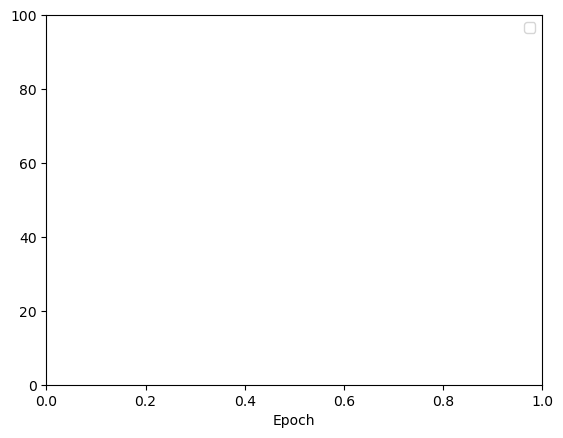

In [26]:
import matplotlib.pyplot as plt

loss_map_bs = list(filter(lambda x: 'lr_0.01_bs_4_seed_0' in x, loss_map))

plt.figure()

for model_name in loss_map_bs:
    plt.plot(loss_map[model_name], label=model_name)
    
plt.xlabel('Epoch')
plt.legend()
plt.ylim(0, 100)

In [86]:
import pandas as pd
time_df = pd.DataFrame(columns=['model','optimizer', 'lossfunc', 'scheduler' ,'lr', 'bs', 'time'])
for batch in batch_size:
    for learning_rate in learning_rates:
        
        time_by_model = {}
        
        for key in time_map:
            key_dict = json.loads(key)
            model_name = key_dict['model']
            lr = key_dict['lr']
            bs = key_dict['bs']
            seed = key_dict['seed']
            
            if batch != bs and lr != learning_rate:
                continue
            if model_name not in time_by_model:
                time_by_model[model_name] = []
            time_by_model[model_name].append(time_map[key][0])
        # print(f"Batch size: {batch}, Learning rate: {learning_rate}")
        # print(time_by_model)
        for key in time_by_model:
            # print("Model: {:20s} time:{:2.3f}s +- {:}{:2.3}s".format(key, np.mean(time_by_model[key]) / 1000,'', np.std(time_by_model[key]) / 1000))

            time_df.loc[len(time_df)] = {"model": key,"lr":learning_rate, "bs":batch,'optimizer':'SGD', 'lossfunc':'CrossEntropy', 'scheduler':'-',  "time":"%.2fs+- %.2fs"%(np.mean(time_by_model[key]) / 1000 , np.std(time_by_model[key]) / 1000)}
            # print(f"Model: {key}, time: {np.mean(time_by_model[key]) / 1000:.2f}s +- {np.std(time_by_model[key]) / 1000:.2f}s")
        # time_df.append(pd.DataFrame(l))
        print("\n")
time_df.reset_index(drop=True)

,model,optimizer,lossfunc,scheduler,lr,bs,time
0,resnet18,SGD,CrossEntropy,-,0.0100,4,10.33s+- 5.26s
1,shufflenet_v2_x1_0,SGD,CrossEntropy,-,0.0100,4,19.99s+- 11.13s
2,resnext50_32x4d,SGD,CrossEntropy,-,0.0100,4,27.90s+- 13.76s
3,resnet18,SGD,CrossEntropy,-,0.0010,4,10.40s+- 5.22s
4,shufflenet_v2_x1_0,SGD,CrossEntropy,-,0.0010,4,20.58s+- 10.90s
5,resnext50_32x4d,SGD,CrossEntropy,-,0.0010,4,27.53s+- 13.80s
6,resnet18,SGD,CrossEntropy,-,0.0001,4,10.42s+- 5.15s
7,shufflenet_v2_x1_0,SGD,CrossEntropy,-,0.0001,4,20.26s+- 11.00s
8,resnext50_32x4d,SGD,CrossEntropy,-,0.0001,4,27.42s+- 14.08s
9,resnet18,SGD,CrossEntropy,-,0.0100,8,8.38s+- 4.27s


In [97]:
acc_df = pd.DataFrame(columns=['model','optimizer', 'lossfunc', 'scheduler' ,'lr', 'bs', 'acc'])
for batch in batch_size:
    for learning_rate in learning_rates:
        
        accuracy_by_model = {}
        
        for key in acc_map:
            key_dict = json.loads(key)
            model_name = key_dict['model']
            lr = key_dict['lr']
            bs = key_dict['bs']
            seed = key_dict['seed']
            
            if batch != bs and lr != learning_rate and seed != 4:
                continue
            if model_name not in accuracy_by_model:
                accuracy_by_model[model_name] = []
            accuracy_by_model[model_name].append(acc_map[key][0])
        # print(f"Batch size: {batch}, Learning rate: {learning_rate}")
        print(accuracy_by_model)
        for key in accuracy_by_model:
            print("Model: {:20s} acc:{:.3f}+-{:.3f}%".format(key, np.mean(accuracy_by_model[key]), np.std(accuracy_by_model[key])))
            
            acc_df.loc[len(acc_df)] = {"model": key,"lr":learning_rate, "bs":batch,'optimizer':'SGD', 'lossfunc':'CrossEntropy', 'scheduler':'-',  "acc":"%.2f+- %.2f"%(np.mean(accuracy_by_model[key])  , np.std(accuracy_by_model[key]) )}
            # print(f"Model: {key}, acc: {np.mean(accuracy_by_model[key]) :.2f} +- {np.std(accuracy_by_model[key]) :.2f}%")
        print("\n")
acc_df

{'resnet18': [68.75, 68.75, 68.75, 68.75, 68.75, 67.0, 67.0, 67.0, 67.0, 67.0, 71.75, 71.75, 71.75, 71.75, 71.75, 71.5, 71.5, 71.5, 71.5, 71.5, 47.0, 47.0, 47.0, 47.0, 47.0, 66.0, 69.75, 64.25, 63.75, 63.75, 63.75, 63.75, 63.75, 73.0, 65.0, 62.5], 'shufflenet_v2_x1_0': [71.75, 71.75, 71.75, 71.75, 71.75, 61.25, 61.25, 61.25, 61.25, 61.25, 48.5, 48.5, 48.5, 48.5, 48.5, 68.75, 68.75, 68.75, 68.75, 68.75, 67.0, 67.0, 67.0, 67.0, 67.0, 50.0, 52.0, 55.75, 52.75, 52.75, 52.75, 52.75, 52.75, 58.75, 52.25, 53.75], 'resnext50_32x4d': [65.5, 65.5, 65.5, 65.5, 65.5, 62.0, 62.0, 62.0, 62.0, 62.0, 69.75, 69.75, 69.75, 69.75, 69.75, 63.75, 63.75, 63.75, 63.75, 63.75, 51.0, 51.0, 51.0, 51.0, 51.0, 72.75, 62.0, 66.75, 50.25, 50.25, 50.25, 50.25, 50.25, 60.25, 56.5, 54.5]}
Model: resnet18             acc:65.257+-7.904%
Model: shufflenet_v2_x1_0   acc:60.347+-8.381%
Model: resnext50_32x4d      acc:60.667+-7.141%


{'resnet18': [68.75, 68.75, 68.75, 68.75, 68.75, 67.0, 71.75, 71.5, 47.0, 47.0, 47.0, 47.0

,model,optimizer,lossfunc,scheduler,lr,bs,acc
0,resnet18,SGD,CrossEntropy,-,0.0100,4,65.26+- 7.90
1,shufflenet_v2_x1_0,SGD,CrossEntropy,-,0.0100,4,60.35+- 8.38
2,resnext50_32x4d,SGD,CrossEntropy,-,0.0100,4,60.67+- 7.14
3,resnet18,SGD,CrossEntropy,-,0.0010,4,64.12+- 7.37
4,shufflenet_v2_x1_0,SGD,CrossEntropy,-,0.0010,4,58.04+- 7.96
5,resnext50_32x4d,SGD,CrossEntropy,-,0.0010,4,61.33+- 7.79
6,resnet18,SGD,CrossEntropy,-,0.0001,4,64.17+- 7.71
7,shufflenet_v2_x1_0,SGD,CrossEntropy,-,0.0001,4,58.82+- 7.53
8,resnext50_32x4d,SGD,CrossEntropy,-,0.0001,4,57.97+- 6.28
9,resnet18,SGD,CrossEntropy,-,0.0100,8,68.40+- 4.70


### With Data Augmentation

In [34]:
from numpy.random import RandomState
import numpy as np
import torch.optim as optim
from torch.utils.data import Subset
from torchvision import datasets, transforms

normalize = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))

transform_val = transforms.Compose([transforms.ToTensor(),
                                    transforms.Resize((32,32)),
                                    transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
                                    transforms.RandomHorizontalFlip(p=0.8),
                                    transforms.RandomRotation(degrees=(0, 30)),
                                    transforms.RandomAutocontrast(),
                                    transforms.ColorJitter(brightness=.5, hue=.5, saturation=.5, contrast=.5),
                                    transforms.GaussianBlur(kernel_size=(5,5), sigma=0.7),
                                    normalize]) #careful to keep this one same

transform_train = transforms.Compose([transforms.ToTensor(),
                                      transforms.Resize((32,32)),
                                      transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
                                      transforms.RandomHorizontalFlip(p=0.8),
                                      transforms.RandomRotation(degrees=(0, 30)),
                                      transforms.RandomAutocontrast(),
                                      transforms.ColorJitter(brightness=.5, hue=.5, saturation=.5, contrast=.5),
                                      transforms.GaussianBlur(kernel_size=(5,5), sigma=0.7),
                                      normalize])

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

##### Cifar Data
cifar_data = datasets.CIFAR10(root='.',train=True, transform=transform_train, download=True)

#We need two copies of this due to weird dataset api
cifar_data_val = datasets.CIFAR10(root='.',train=True, transform=transform_val, download=True)

for model_name in model_names:
    print(f"Training model: {model_name}")
    for lr in learning_rates:
      for bs in batch_size:
        model_accs = []
        model_losses = []

        for seed in range(0, 5):
          loss_epoch=[]
          save_name = model_name + '_lr_' + str(lr) + '_bs_' + str(bs) + '_seed_' + str(seed)

          prng = RandomState(seed)
          random_permute = prng.permutation(np.arange(0, 1000))
          classes =  prng.permutation(np.arange(0,10))
          indx_train = np.concatenate([np.where(np.array(cifar_data.targets) == classe)[0][random_permute[0:25]] for classe in classes[0:2]])
          indx_val = np.concatenate([np.where(np.array(cifar_data.targets) == classe)[0][random_permute[25:225]] for classe in classes[0:2]])
          # print(classes)

          train_data = Subset(cifar_data, indx_train)
          val_data = Subset(cifar_data_val, indx_val)

          # print('Num Samples For Training %d Num Samples For Val %d'%(train_data.indices.shape[0],val_data.indices.shape[0]))

          train_loader = torch.utils.data.DataLoader(train_data,
                                                    batch_size=bs,
                                                    shuffle=True)
          # print(train_loader)

          val_loader = torch.utils.data.DataLoader(val_data,
                                                  batch_size=128,
                                                  shuffle=False)

          model = create_model(model_name)
          model.to(device)
          optimizer = torch.optim.SGD(model.parameters(),lr=lr, momentum=0.9, weight_decay=0.0005)

          for epoch in range(50):
            loss_by_epoch = train(model, device, train_loader, optimizer, epoch, display=epoch%5==0)
            loss_epoch.append(loss_by_epoch)
          # accs.append(test(model, device, val_loader))
          accuracy, val_loss = test(model, device, val_loader)
          model_accs = np.append(model_accs, accuracy)
          model_losses = np.append(model_losses, val_loss)
          print(f"Accuracy for {model_name} (Instance {seed+1}): {accuracy:.2f}%\n")

          model_accs = np.array(model_accs)
          model_losses = np.array(model_losses)
          loss_map[save_name] = loss_epoch
          acc_map[save_name] = model_accs
          
        print('Acc over 5 instances: %.2f +- %.2f'%(model_accs.mean(),model_accs.std()))


        result_dict = {'accuracy': model_accs, 'validation_loss': model_losses}
        filename = f"{model_name}_accuracy_validation_loss.pkl"
        with open(filename, 'wb') as f:
            pickle.dump(result_dict, f)
        print(f"Results for {model_name} saved in {filename}------------------------------------------------------\n")

Files already downloaded and verified
Files already downloaded and verified
Training model: resnet18


/home/nishant/anaconda3/envs/comp691/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nishant/anaconda3/envs/comp691/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Train Epoch: 0 [24/50 (92%)]	Loss: 0.020624
Train Epoch: 5 [24/50 (92%)]	Loss: 0.249433
Train Epoch: 10 [24/50 (92%)]	Loss: 0.000002
Train Epoch: 15 [24/50 (92%)]	Loss: 1.252402
Train Epoch: 20 [24/50 (92%)]	Loss: 2.291460
Train Epoch: 25 [24/50 (92%)]	Loss: 0.150240
Train Epoch: 30 [24/50 (92%)]	Loss: 1.912658
Train Epoch: 35 [24/50 (92%)]	Loss: 0.505114
Train Epoch: 40 [24/50 (92%)]	Loss: 2.298244
Train Epoch: 45 [24/50 (92%)]	Loss: 0.359438


/home/nishant/anaconda3/envs/comp691/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.9391, Accuracy: 219/400 (54.75%)
Accuracy for resnet18 (Instance 1): 54.75%

Train Epoch: 0 [24/50 (92%)]	Loss: 10.196568
Train Epoch: 5 [24/50 (92%)]	Loss: 0.000042
Train Epoch: 10 [24/50 (92%)]	Loss: 0.000527
Train Epoch: 15 [24/50 (92%)]	Loss: 0.043680
Train Epoch: 20 [24/50 (92%)]	Loss: 1.057700
Train Epoch: 25 [24/50 (92%)]	Loss: 0.245480
Train Epoch: 30 [24/50 (92%)]	Loss: 0.039334
Train Epoch: 35 [24/50 (92%)]	Loss: 0.916911
Train Epoch: 40 [24/50 (92%)]	Loss: 0.109726
Train Epoch: 45 [24/50 (92%)]	Loss: 1.047415

Test set: Average loss: 7.1622, Accuracy: 234/400 (58.50%)
Accuracy for resnet18 (Instance 2): 58.50%

Train Epoch: 0 [24/50 (92%)]	Loss: 1.535734
Train Epoch: 5 [24/50 (92%)]	Loss: 0.000372
Train Epoch: 10 [24/50 (92%)]	Loss: 9.299460
Train Epoch: 15 [24/50 (92%)]	Loss: 2.313157
Train Epoch: 20 [24/50 (92%)]	Loss: 0.761015
Train Epoch: 25 [24/50 (92%)]	Loss: 1.839459
Train Epoch: 30 [24/50 (92%)]	Loss: 4.513049
Train Epoch: 35 [24/50 (92%)]	

(0.0, 100.0)

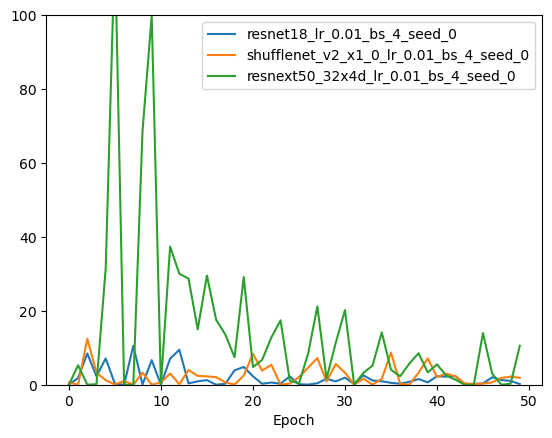

In [35]:
import matplotlib.pyplot as plt

loss_map_bs = list(filter(lambda x: 'lr_0.01_bs_4_seed_0' in x, loss_map))

plt.figure()

for model_name in loss_map_bs:
    plt.plot(loss_map[model_name], label=model_name)
    
plt.xlabel('Epoch')
plt.legend()
plt.ylim(0, 100)